In [1]:
import bisect
import numpy as np
from obspy.clients import fdsn
import matplotlib.pyplot as plt
from obspy.core import UTCDateTime

# For correlation
from __future__ import print_function
from scipy.signal import correlate, correlation_lags
from obspy.signal.cross_correlation import xcorr_pick_correction

import warnings
warnings.filterwarnings("ignore")

# 1) Funções



In [2]:
# 1) Get phase time pick and waveform_id.id (net, sta, loc, chan)
def evpicks(evid, phases = ['P']):
    '''
    str, list['str'] --> str, float

    Connect to SeisVL and get the event corresponded to ID given.
    After that, gets the first event preferred origin and it's arrivals and
    yield station code (net.sta.loc.chan) and the time pick of phases  list
    given.
    '''
    
    #Connecta na SeisVL
    cl_e = fdsn.Client("http://10.110.0.135:18003") #SeisVL

    #Confere se o ID existe na SeisVL
    try:
        evp = cl_e.get_events(eventid = evid, includearrivals=True)
    except:
        return print(f'No event with {evid} ID detected. Make sure it is in Vale event list (val2025....)!') # None

    #Pega o 1o evento e sua origem preferida
    E = evp[0]
    O = E.preferred_origin()

    # Faço um laço para as chegadas, pois delas eu tiro a fase que eu quero + ID
    # Com o ID de A eu comparo com o ID do Pick, se bater eu fico com o Pick (que carrega
    # informação do tempo e da waveform ID, que é o código da estação)
    for A in O.arrivals:
        if A.time_weight <= 0.0: continue
        if A.phase not in phases: continue
        P = [ P for P in E.picks if P.resource_id == A.pick_id ][0]

        # Yield é tipo um return, mas que continua o loop e não para a função
        yield (P.waveform_id.id, P.time) #waveform_id.id é o código da estação

#####################################################################################################################################################################
# 2) Get trace information and UTC and Relative time of each sample
def evtrace(sta, tp, t0, t1, fmin=2.0, fmax=10.0, margin = 2.0):
    '''
    str, float, float, float, float (opt), float (opt), float (opt) --> numpy.ndarray, numpy.ndarray

    Connect to SeisVL and get the waveform of a given period of time, returning the 
    waverform and the relative time.
    '''
    
    ## Clients
    cl_e = fdsn.Client("http://10.110.0.135:18003")
    data = cl_e.get_waveforms(*sta.split("."), starttime=t0 - margin, endtime=t1 + margin, attach_response=True)
    
    ## Errors
    ##
    if len(data) == 0:
        raise Exception("No data")
    elif len(data) > 1:
        raise Exception("Data with gap")
    
    ## Process
    ##
    trace = data[0]
    trace.detrend()
    trace.filter("bandpass", freqmin=fmin, freqmax=fmax)
    trace.trim(t0,t1)
    
    ## Return
    ##
    #OBS: A data tem que ser um obspy.Trace para rodar a correlação depois
    # data   = trace #.data
    
    # Estou retornando tempo UTC e Relativo
    # UTC pois precisa para a função de correlação
    # E relativo pelo fato de ser mais conveniente na hora de plotar a waveform 
    # times_utc  = trace.times("utcdatetime")
    # times_r = times_utc - tp 
    
    return trace


# 3) Trim 2 traces starting at the same (or nearest possible) time with same number of samples
def same_length(small, big, t0, offset=0, n_samples=None):
    """
    Trace, Trace, float, list, float(opt) --> Trace, Trace

    Arguments:

    small: obspy.core.trace.Trace (must contain .data, .time and
           .stats.delta)

    big: obspy.core.trace.Trace (must contain .data, .time and
           .stats.delta)

    t0: float (initial time to trim data)

    n_samples: float (number of samples new traces must have)

    n_sec: float (number of seconds that new trace should have)

    Gets two traces and the initial time. Cut both traces with the same
    amount of samples, moving, if necessary, the interval's limits to
    the nearest sample.

    By default, if n_samples is not given, is used the number of samples
    is equal 2s of 'small' seismometer acquisition samples.
    """

    if len(small.data) > len(big.data):
        raise Exception(f"The trace 'small' is bigger than 'big'. "
                        f"Please, switch this arguments position.")
    if len(small.data) == len(big.data):
        return small, big

    dt = small.stats.delta
    if n_samples is None:
        n_samples = int(2 * 1/dt)

    # Trimming SMALL
    # finding initial time to trim (small_ti)
    times_small = small.times()
    find=False
    cont=0
    for i, t in enumerate(times_small[:-1]):
        if len(small) == n_samples:
            break
        if find:
            cont += 1
        if t == t0:
            small_ti = t0
            cont = 1
            find=True
        elif t + dt > t0 and not find:
            if abs(t) - abs(t0) <= abs(times_small[i+1]) - abs(t0):
                small_ti = t
                cont = 1
            else:
                small_ti = times_small[i+1]
                cont = 0
            find=True
        # finding final time to trim (small_tf)
        if cont == n_samples:
            small_tf = t
            break
    if find:
        if cont+1 < n_samples:
            raise Exception(f"{n_samples} samples exceeds number of samples"
                        f" after t0(total={cont}) for trace 'small'")
    if find:
        tr = small.stats.starttime
        small.trim(tr+small_ti, tr+small_tf)

    # Trimming BIG
    # finding initial time to trim (big_ti)
    times_big = big.times()+offset
    start = times_big[0]
    find=False
    cont=0
    for i, t in enumerate(times_big[:-1]):
        if find:
            cont+=1
        if t == t0:
            big_ti = np.abs(t0-start)
            cont = 1
            find=True
        elif t + dt > t0 and not find:
            if abs(t) - abs(t0) <= abs(times_big[i+1]) - abs(t0):
                big_ti = np.abs(t-start)
                cont = 1
            else:
                big_ti = times_big[i+1]
                cont = 0
            find=True
        
        # finding final time to trim (big_tf)
        if cont == n_samples:
            big_tf = np.abs(t-start)
            break    
    if cont+1 < n_samples:
        raise Exception(f"{n_samples} samples exceeds number of samples"
                        f" after t0(total={cont}) for trace 'big'")
    tr = big.stats.starttime
    big.trim(tr+big_ti, tr+big_tf)

    return small, big


# 4) Pick correction function
def Ppick_cc(trace1, trace2, maxshift):
    """
    Trace, Trace --> list, list, float

    Utilizes cross-correlation between two given traces to 
    correct P phase pick.
    """
    dt = trace1.stats.delta
    corr = correlate(trace1.data, trace2.data, mode='valid')
    lags = correlation_lags(len(trace1.data), len(trace2.data), mode='valid')
    
    if abs(lags[corr.argmax()] * dt) <= maxshift:
        OFFSET = lags[corr.argmax()] * dt
    else:
        OFFSET = 0

    return corr, lags, OFFSET


## Print da matriz
def plot_matrix(ev_id, matrix):
    size = len(ev_id)

    print('Matriz de correlação:')
    for i in range(size):
        print('|', end='   ')
        for j in range(size):
            if matrix[i,j] < 0:
                print(f'{matrix[i,j]:.2f}', end='   ')
            else:
                print(f'{matrix[i,j]:.2f}', end='    ')
        print('|', end ='')        
        print()


    print(f'\n\n')

def corr_matrix(ev_id, station, t0=0, phase=["P"], fmin=5,fmax=15, start1=0.2,start2=4, end1=2,end2=2, maxshift=20, n_samples=None, correction=True,
                plot=True, figsize=(16,9), cmap='Accent_r'):
    """

    Creates a color correlation matrix.

    ev_id: list of events IDs.

    station: station code (example: VL.SLBO..HHZ).

    t0: initial time to trim data in seconds [s].

    phase: list with the phase you would like to make a graph.

    fmin: minimum frequency [Hz] to cut (high-pass).
    fmax: maximum frequency [Hz] to cut (low-pass).

    start1: beginning of first trace (must be the smaller one). 
            Time in seconds [s] before P arrival.
    start2: beginning of second trace (must be the bigger one).
            Time in seconds [s] before P arrival.

    end1: end of first trace (must be the smaller one).
          Time in seconds [s] after P arrival.
    end2: end of second trace (must be the bigger one).
          Time in seconds [s] after P arrival.

    maxshift: maximum shift allowed in seconds [s].

    n_samples: number of samples to cut traces.

    correction: condition if the finction should make a cross-correlation pick correction.

    plot: condition if the function should plot the graph or only return the matrix.

    figsize: size of figure (example: (x, y) ou (16,9)).

    cmap: color to be used to make the colorbar.
    """
    
    size = len(ev_id)
    # Recriando o gráfico de correlação pós ajuste
    Mcorr = np.ones([size, size])
    
    # Criando duas listas para arnazenar os lag e as formas de ondas pós correlação
    info_dict = {'data1':[], 'data2':[],'lags':[],'corr':[], 'offset' : [], 'title': []}
    
    # Laço que passa por todos os eventos em ev_id e faz a leitura e correção do pick de P para as réplicas que foram
    # registradas pela variável "station"
    
    for i in range(size):
        # Passa a lista ev_id e tira os dados da "station"
        for s1, t1 in evpicks(ev_id[i], phases=phase):
            if s1 == station:
                data1 = evtrace(station, t1, t1-start1, t1+end1, fmin, fmax)
                dt = data1.stats.delta
    
                # Passa a lista ev_id e tira as formas de ondas dos demais eventos que aconteceram em "station"
                for j in range(i + 1, size):
                    for s2, t2 in evpicks(ev_id[j], phases=['P']):
                        if s2 == station:
                            # Aqui vai ser feito uma análise com um chute inicial
                            data2 = evtrace(station, t2, t2-start2, t2+end2, fmin, fmax)

                            if correction:
                                corr, lags, OFFSET = Ppick_cc(data1,data2, maxshift)
                                FACTOR1 = 1/np.max(data1.data)
                                FACTOR2 = 1/np.max(data2.data)
                                
                                info_dict['data1'].append(data1)
                                info_dict['data2'].append(data2)
                                info_dict['lags'].append(lags)
                                info_dict['corr'].append(corr)
                                info_dict['offset'].append(OFFSET)
                                info_dict['title'].append(f'{ev_id[i]}  -X-  {ev_id[j]}')
                                
                                data1, data2 = same_length(data1, data2, t0, offset=OFFSET, n_samples=n_samples)
                            Mcorr[i,j] = np.abs(np.corrcoef(data1.data, data2.data)[0][1])
    
    for i in range(size):
        for j in range(size):
            if j>i:
                Mcorr[j][i] = -1
    
    #################################
    if plot:
        # Plota o gráfico (está em uma célula a parte, pois se for mudar a paleta de cores não demora tanto)
        Max = np.max(np.abs(Mcorr))
        Min = -Max
        plt.figure(figsize=figsize)
        plt.imshow(Mcorr, cmap=cmap, vmin = Min, vmax = Max)
        plt.colorbar(label='Correlation value')
        plt.xticks(range(size), ev_id, rotation=20)
        plt.yticks(range(size), ev_id)
        plt.title(f'Correlation matrix (corrected)\nStation code: {station}\nNumber of events: {len(ev_id)}')
        plt.show()
    
    return Mcorr
#####################################################################################################################################################################


# 2) Correlação das formas de onda


Plota a matriz de correlação das formas de onda dos eventos listados em "ev_id". Neste caso, não houve correção dos picks da onda P, então o início do evento corresponde puramente ao escolhido pelo sismologo durante a pickagem

In [3]:
# Lista de eventos
ev_id = ['val2025gmqf','val2025gmvl','val2025gmvf','val2025gmqn','val2025gmsc','val2025gnbo']
# Número de estações/dimensão da matriz nxn
size = len(ev_id)
# Estação que será extraída a forma de onda
station = 'VL.SLBO..HHZ'

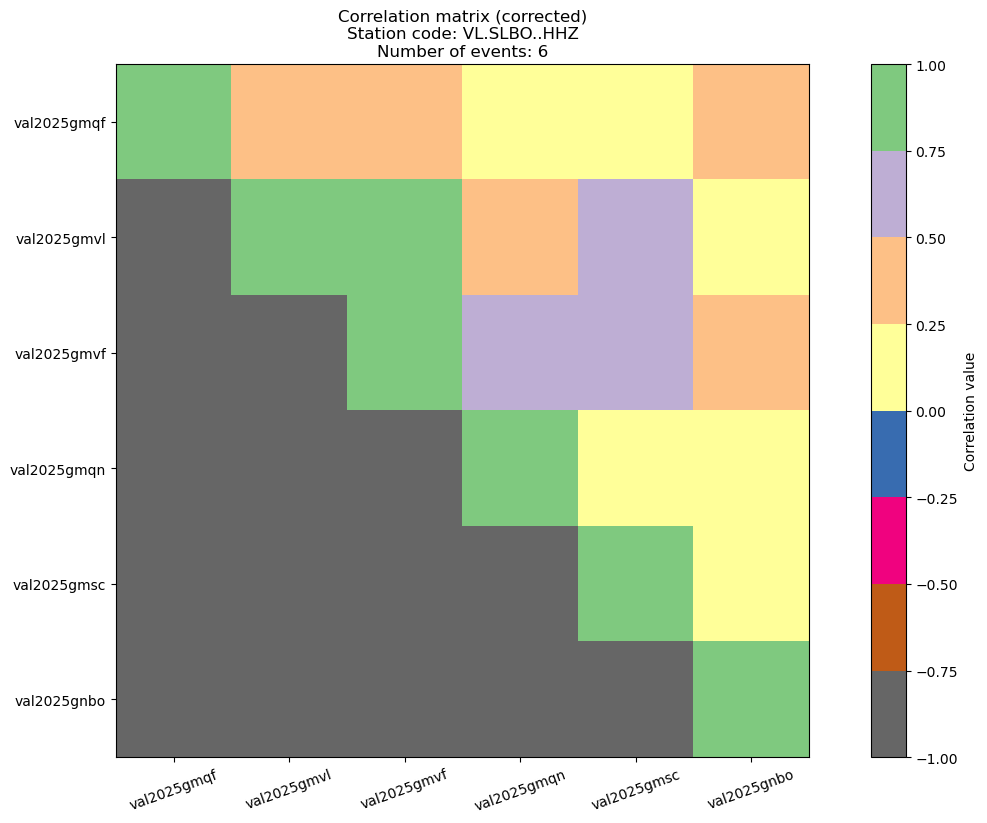

Matriz de correlação:
|   1.00    0.41    0.45    0.12    0.20    0.38    |
|   -1.00   1.00    0.98    0.48    0.67    0.19    |
|   -1.00   -1.00   1.00    0.50    0.63    0.34    |
|   -1.00   -1.00   -1.00   1.00    0.22    0.16    |
|   -1.00   -1.00   -1.00   -1.00   1.00    0.19    |
|   -1.00   -1.00   -1.00   -1.00   -1.00   1.00    |





In [4]:
corr_M = corr_matrix(ev_id, station, t0=0, phase=["P"], fmin=2,fmax=10, start1=0.5,start2=0.5, end1=2,end2=2, maxshift=0, n_samples=None, correction=False,
                plot=True, figsize=(16,9), cmap='Accent_r')

plot_matrix(ev_id, corr_M)

# 3) Correção do pick da fase P

## P pick time correction

IDEIA:

O objetivo é corrigir o tempo de coleta P movendo a coleta para o atraso (que será convertido em tempo relativo multiplicando por dt).

Só precisamos ter cuidado com os problemas de tempo relativo, então, vamos encurtar um traço de dados. Dessa forma, a correlação é válida porque um pode se mover pelo outro sem que nenhum de seus números seja isolado. Sabendo que um é mais curto, é melhor somar ou subtrair a diferença de tempo relativa entre o início dos traços.

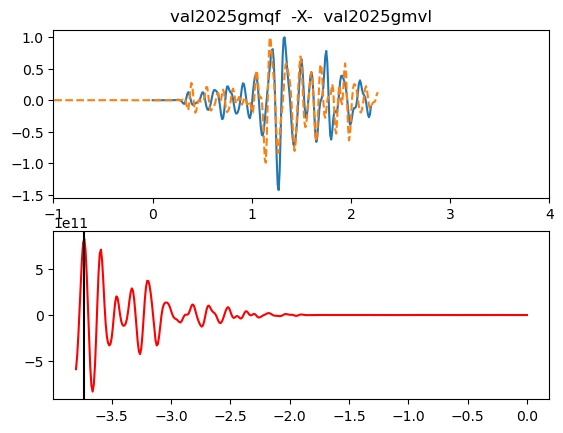

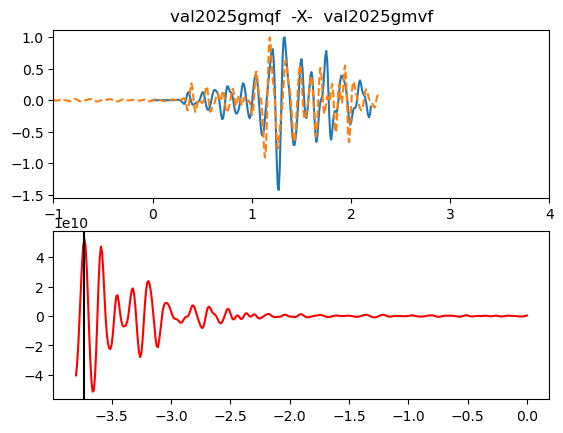

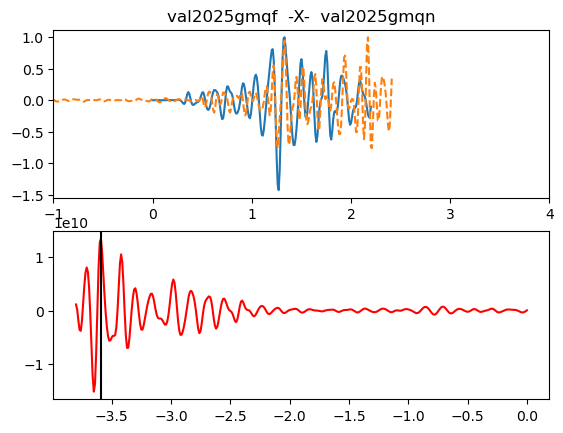

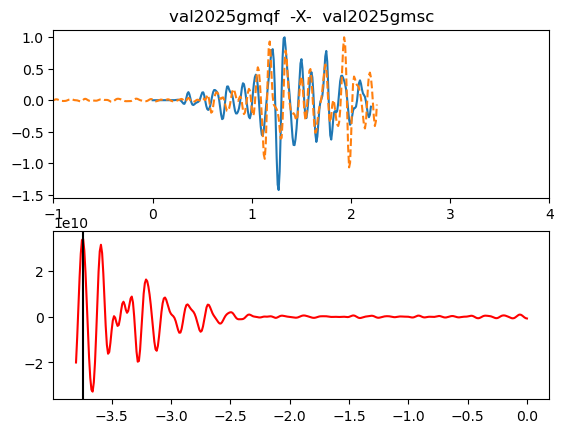

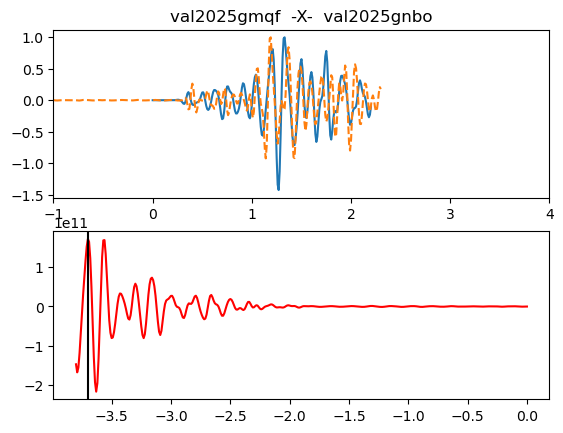

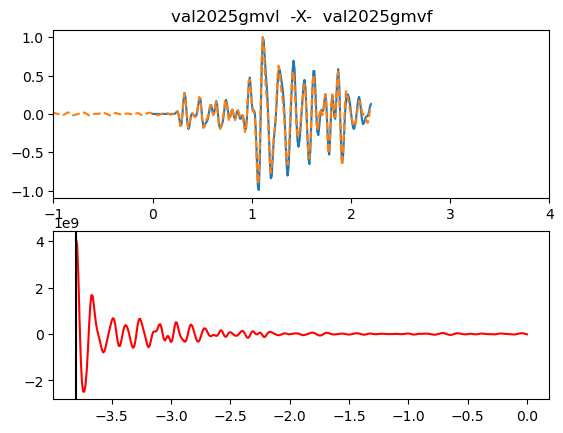

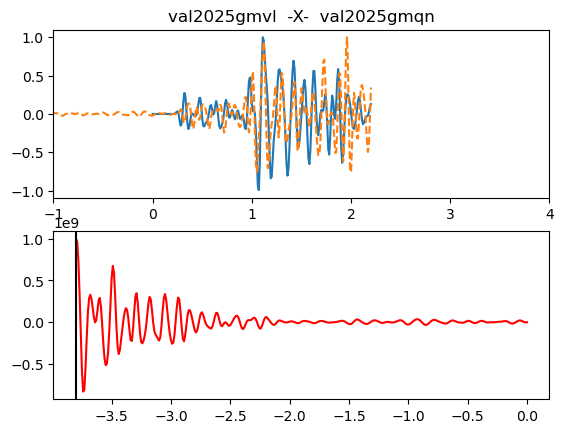

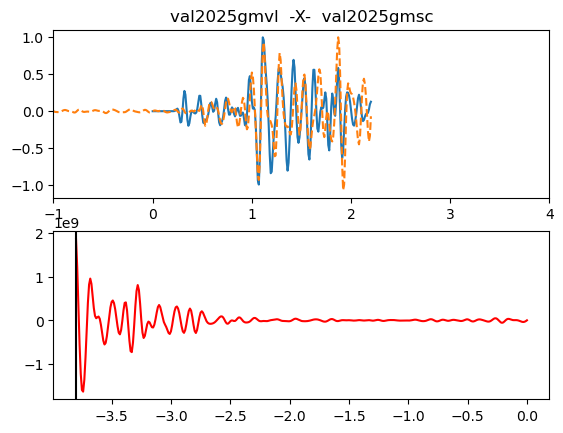

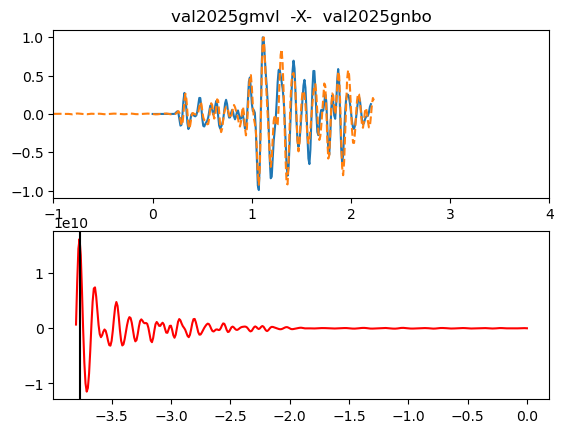

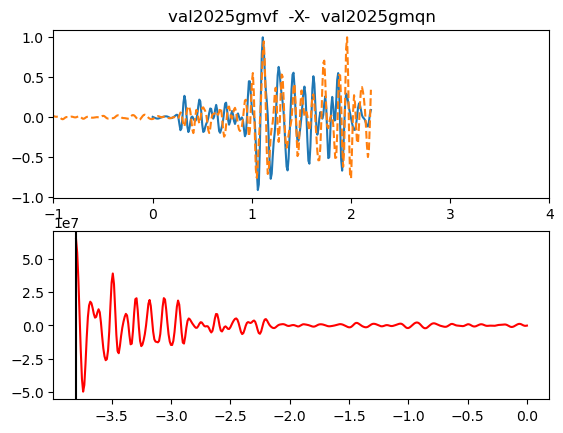

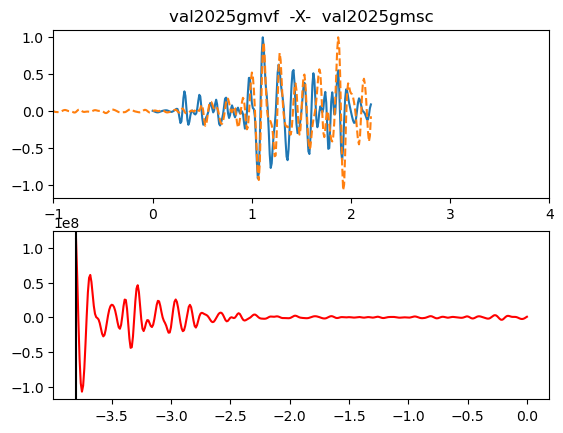

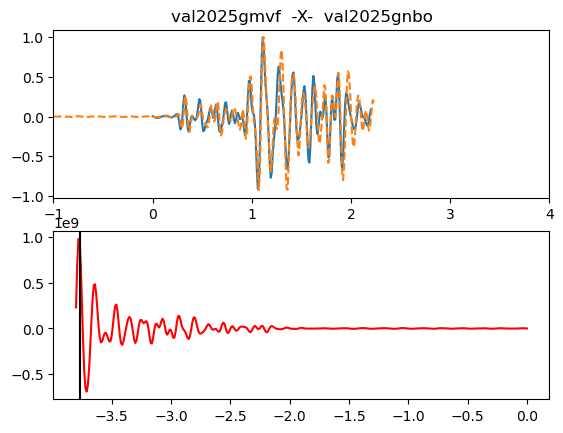

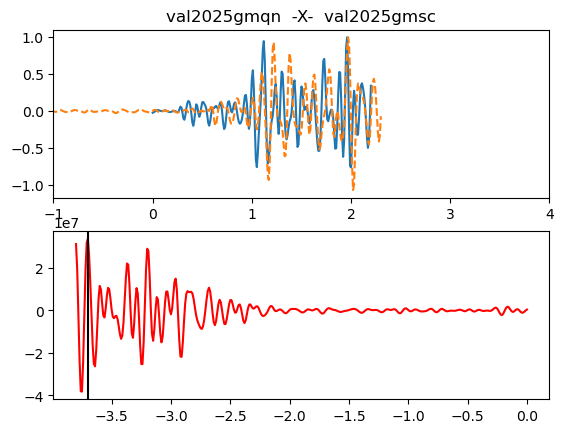

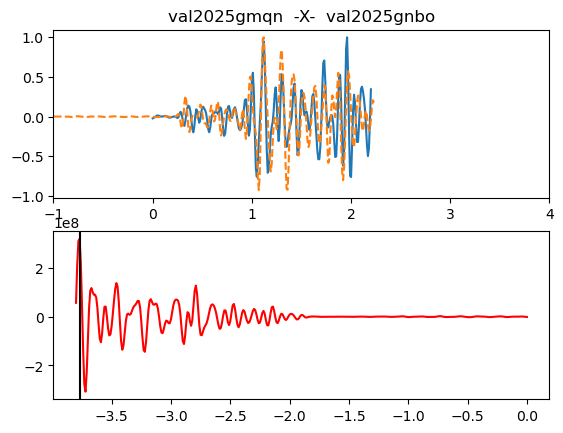

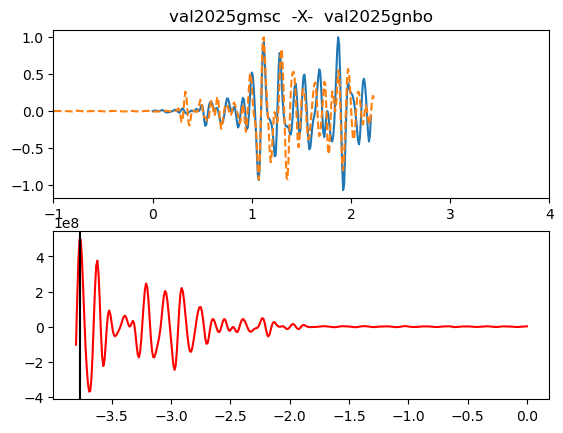

In [5]:
# Fazendo a correção do pick da onda P

# Criando duas listas para arnazenar os lag e as formas de ondas pós correlação
info_dict = {'data1':[], 'data2':[],'lags':[],'corr':[], 'offset' : [], 'title': []}

# Definindo os parâmetros para evpicks e evtrace
# 1) Filtro aplicado
fmin = 5.0
fmax = 15.0

# 2) tamanho do 1o e do 2o traço, em tempo relativo ao pick da onda P
start1 = 0.2
start2 = 4
diff_start = abs(start2 - start1)

end1 = 2
end2 = 2

maxshift= 20 # [s]

# Laço que passa por todos os eventos em ev_id e faz a leitura e correção do pick de P para as réplicas que foram
# registradas pela variável "station"

for i in range(len(ev_id)):
    # Passa a lista ev_id e tira os dados da "station"
    for s1, t1 in evpicks(ev_id[i], phases=['P']):
        if s1 == station:
            data1 = evtrace(station, t1, t1-start1, t1+end1, fmin, fmax)
            dt = data1.stats.delta

            # Passa a lista ev_id e tira as formas de ondas dos demais eventos que aconteceram em "station"
            for j in range(i + 1, len(ev_id)):
                for s2, t2 in evpicks(ev_id[j], phases=['P']):
                    if s2 == station:
                        # Aqui vai ser feito uma análise com um chute inicial
                        data2 = evtrace(station, t2, t2-start2, t2+end2, fmin, fmax)
                        corr , lags, OFFSET = Ppick_cc(data1, data2, maxshift)
                        FACTOR1 = 1/np.max(data1.data)
                        FACTOR2 = 1/np.max(data2.data)
                        
                        info_dict['data1'].append(data1)
                        info_dict['data2'].append(data2)
                        info_dict['lags'].append(lags)
                        info_dict['corr'].append(corr)
                        info_dict['offset'].append(OFFSET)
                        info_dict['title'].append(f'{ev_id[i]}  -X-  {ev_id[j]}')
                        
                        # Plot
                        plt.subplot(2,1,1)
                        plt.title(f'{ev_id[i]}  -X-  {ev_id[j]}')
                        plt.plot(data1.times(), data1.data * FACTOR1)
                        plt.plot(data2.times() + OFFSET, data2.data * FACTOR2, "--")
                        plt.xlim((-5*start1,start2))
                        
                        plt.subplot(2,1,2)
                        plt.plot( lags * dt, corr, color='red')
                        plt.axvline(OFFSET, color ='k')
                        
                        plt.show()



# 4) Gráfico das formas de ondas sobrepostas após a correção de pick

Plotar a matriz de correlação, mas no lugar do mapa de cores, colocar os gráficos com as formas de ondas dos eventos que estão sendo comparados.

## Gráficos

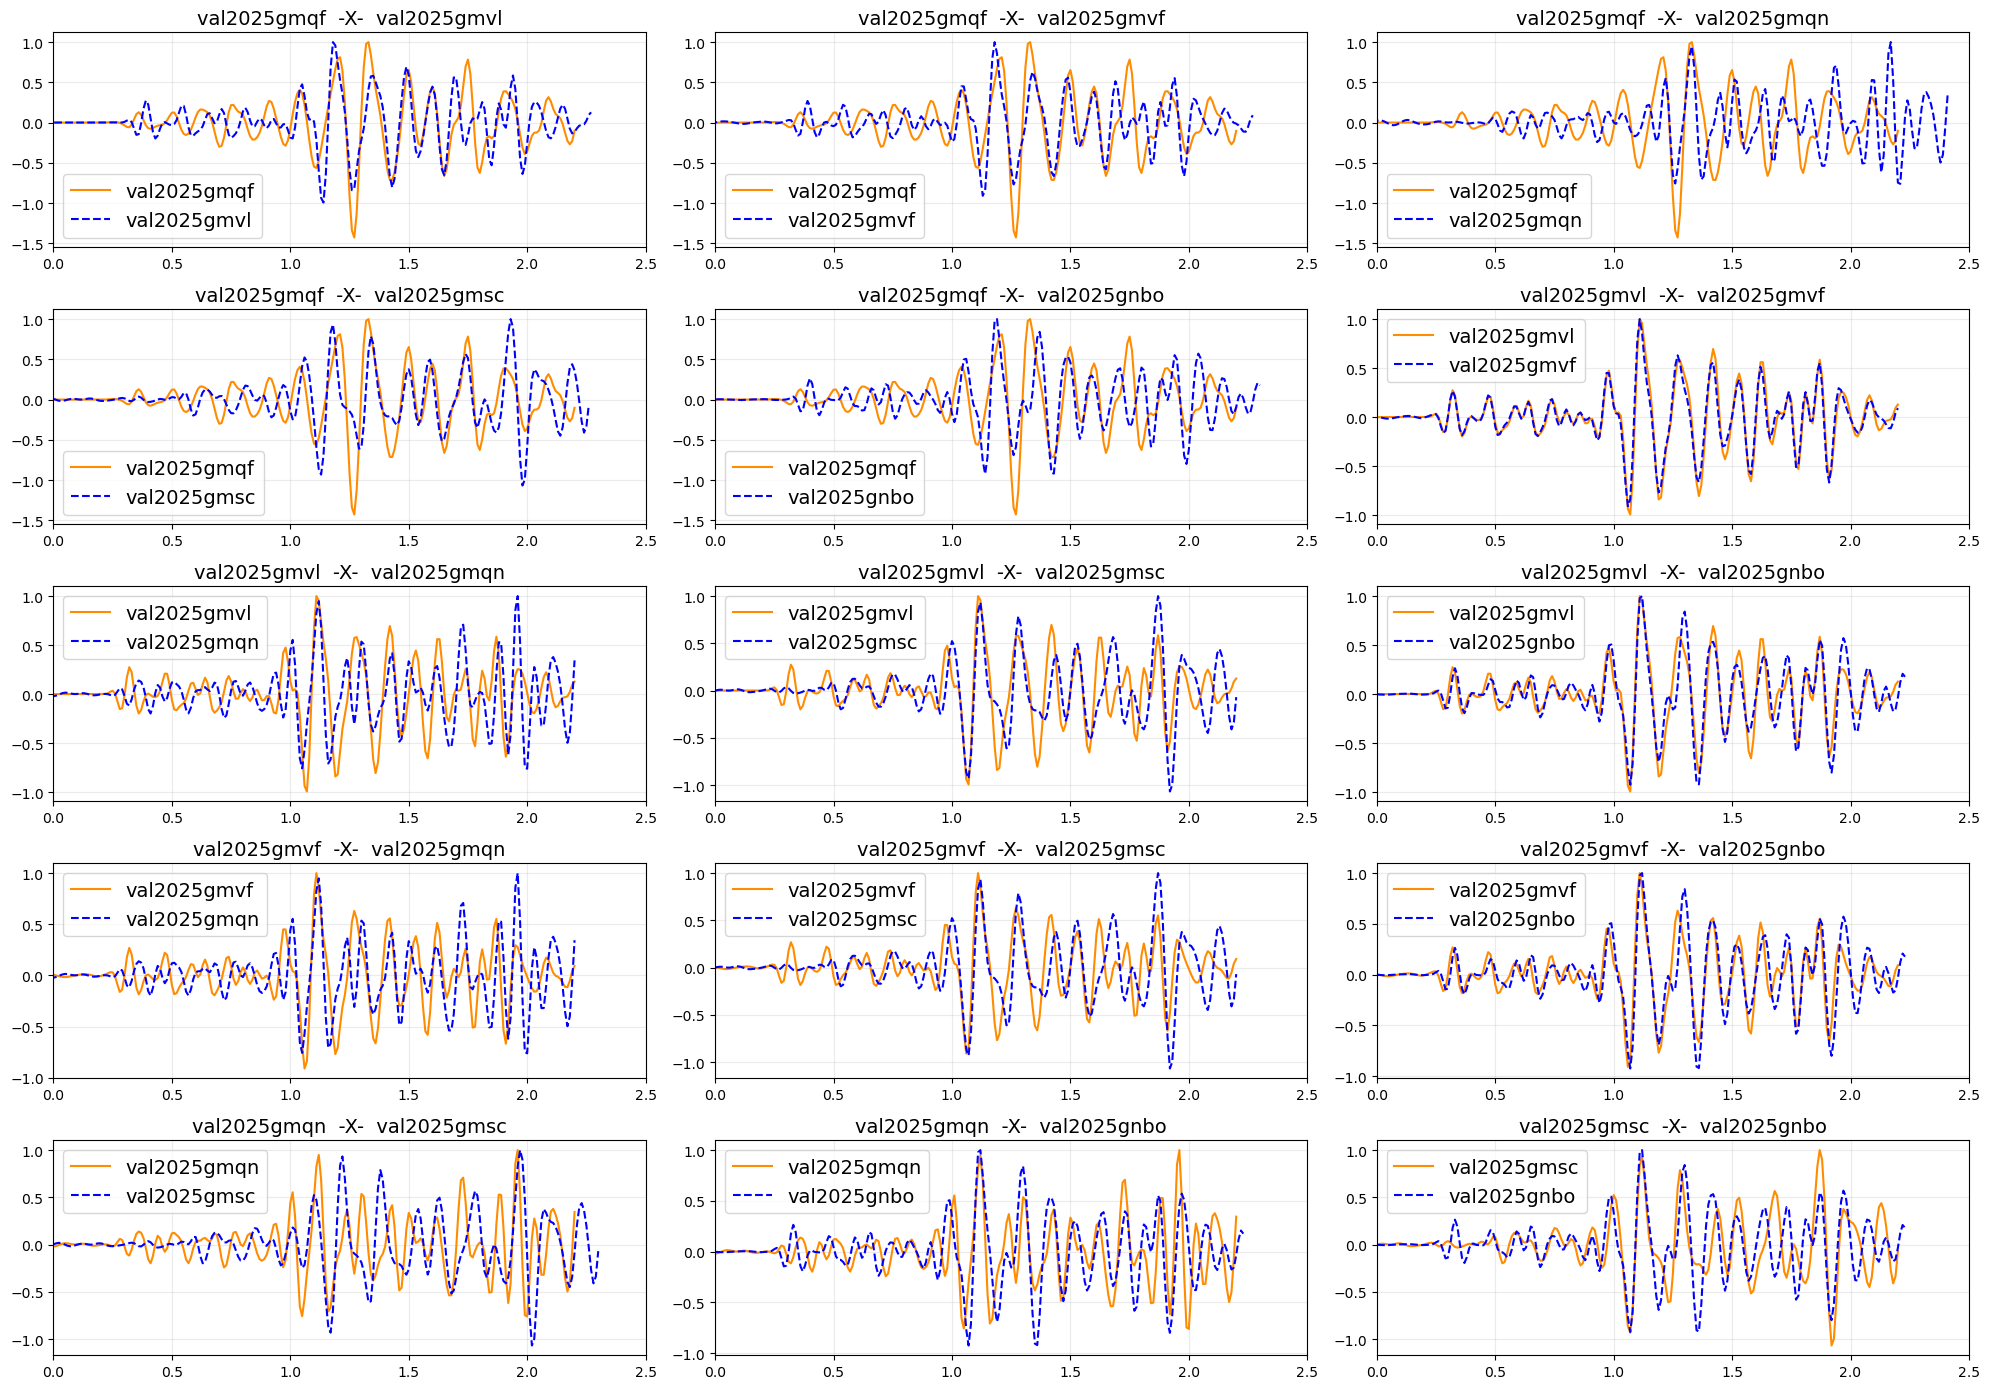

In [6]:
# O número de gráficos deve ser igual ao número de correções que foram feitas
total_de_graficos = len(info_dict['corr'])

# Gostaria que tivesse, no máximo, 5 colunas. Se tiiver menos de 5 gráficos, uma coluna
# para cada gráfico
if total_de_graficos < 5:
    ncols = total_de_graficos
else:
    ncols = 3

# Ajustando o número de linhas de acordo com o npumero de colunas escolhidas (no caso 5)
if total_de_graficos % ncols ==0:
    nrows = total_de_graficos//ncols
    deno = ncols
else:
    nrows = total_de_graficos//ncols + 1
    deno = ncols + 1

# Criando os gráficos
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[20,14], squeeze=False)


# Criando um contador que passará pelo indice do info_dict
cont = 0
for row in range(nrows):
    for col in range(ncols):
        title = info_dict['title'][cont]
        image = ax[row][col]
        # Plot da correlações
        #ax[row][col].plot(info_dict['lags'][cont], info_dict['corr'][cont], color='red')
        
        # Plotando o 1o evento
        Y1 = info_dict['data1'][cont]
        X1 = Y1.times()
        Y1 = Y1.data / np.max(Y1.data)
        
        image.plot(X1, Y1, color='darkorange', label=f'{title[:11]}')
        
        # Plotando o 2o evento
        Y2 = info_dict['data2'][cont]
        X2 = Y2.times() + info_dict['offset'][cont]
        Y2 = Y2.data / np.max(Y2.data)

        image.plot(X2, Y2, 'b--', label=f'{title[18:]}')

        # Configurando o gráfico
        image.set_title(title, fontsize=14)
        image.set_xlim(0.0,2.5)
        image.grid(alpha=0.25)
        image.legend(fontsize=14)
        cont += 1
        
        if cont == total_de_graficos:
            break


plt.tight_layout()

## Recriando a matriz de correlação

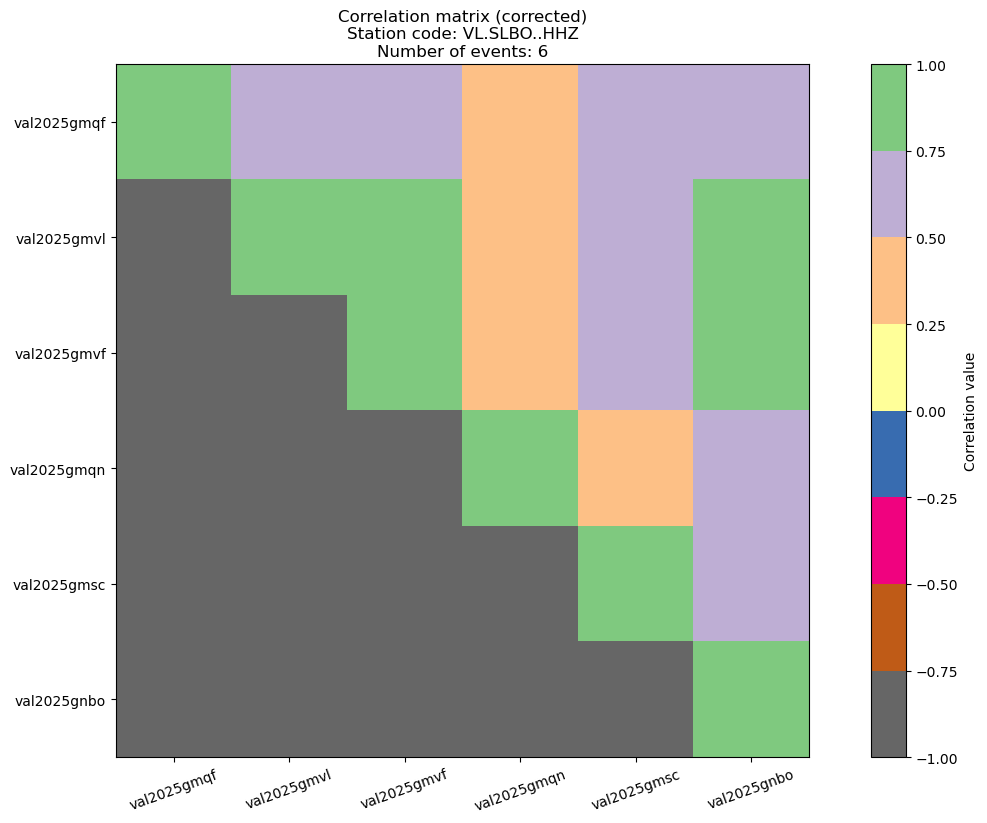

Matriz de correlação:
|   1.00    0.64    0.65    0.37    0.60    0.55    |
|   -1.00   1.00    0.98    0.48    0.70    0.90    |
|   -1.00   -1.00   1.00    0.47    0.73    0.86    |
|   -1.00   -1.00   -1.00   1.00    0.36    0.58    |
|   -1.00   -1.00   -1.00   -1.00   1.00    0.64    |
|   -1.00   -1.00   -1.00   -1.00   -1.00   1.00    |





In [7]:
Mcorr=corr_matrix(ev_id, station, t0=0, phase=["P"], fmin=5,fmax=15, start1=0.2,start2=4, end1=2,end2=2, maxshift=20, n_samples=None, plot=True, figsize=(16,9), cmap='Accent_r')

plot_matrix(ev_id, Mcorr)

# 5) Comparando a matriz de correlação inicial com a corrigida

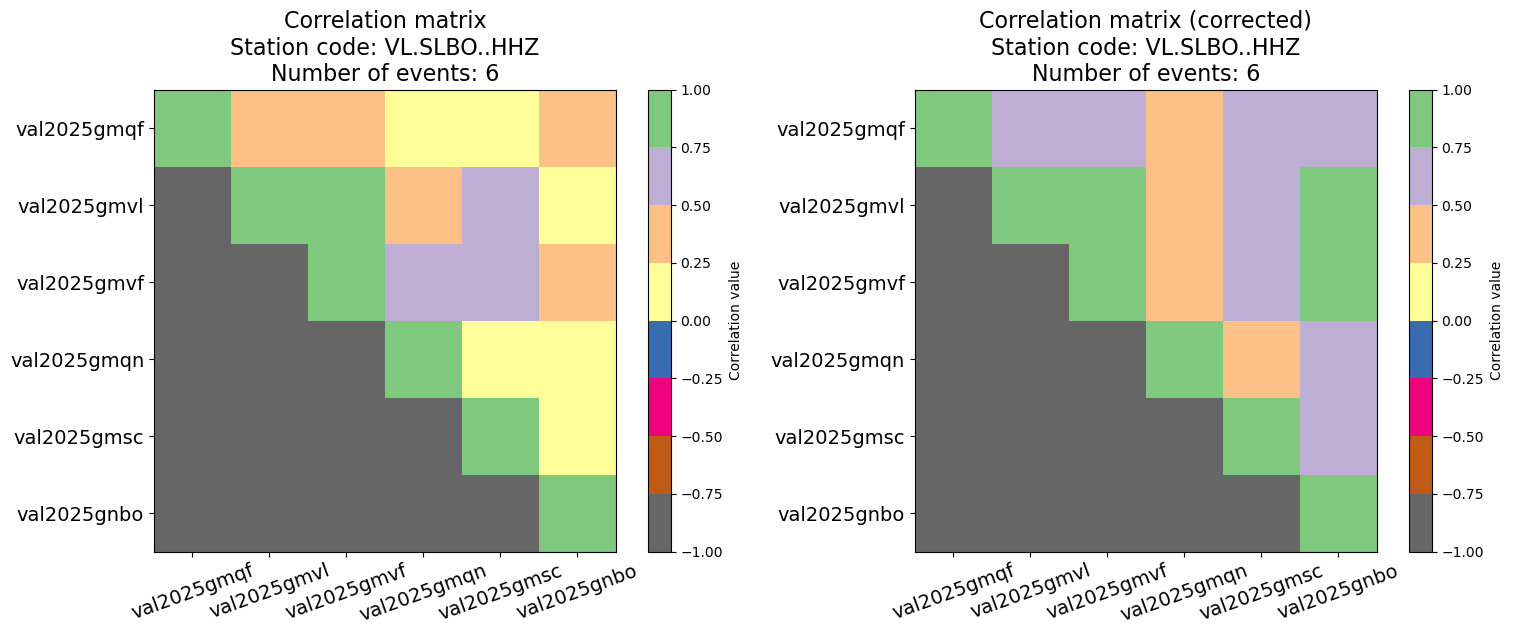

In [8]:
fig, ax = plt.subplots(nrows=1, ncols = 2, figsize=(18, 6))

### Inicial
Max = np.max(np.abs(corr_M))
Min = -Max

im = ax[0].imshow(corr_M, cmap='Accent_r', vmin = Min, vmax = Max)
fig.colorbar(im, label='Correlation value')
ax[0].set_xticks(range(size), ev_id, rotation=20, fontsize=14)
ax[0].set_yticks(range(size), ev_id, fontsize=14)
ax[0].set_title(f'Correlation matrix\nStation code: {station}\nNumber of events: {size}', fontsize=16);



### Corrigida
Max = np.max(np.abs(Mcorr))
Min = -Max

im = ax[1].imshow(Mcorr, cmap='Accent_r', vmin = Min, vmax = Max)
fig.colorbar(im, label='Correlation value')
ax[1].set_xticks(range(size), ev_id, rotation=20, fontsize=14)
ax[1].set_yticks(range(size), ev_id, fontsize=14)
ax[1].set_title(f'Correlation matrix (corrected)\nStation code: {station}\nNumber of events: {size}', fontsize=16);


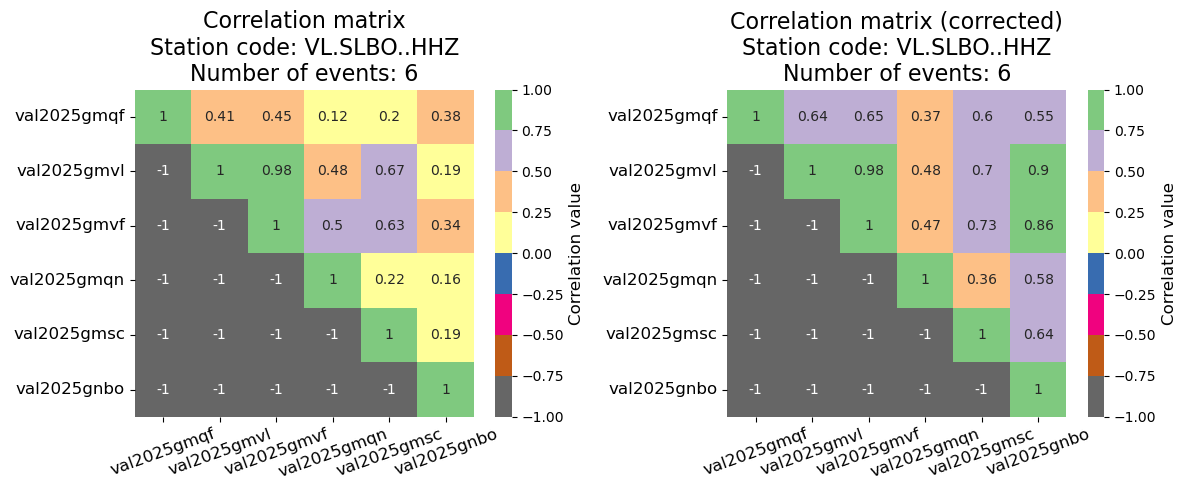

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

### Inicial
Max = np.max(np.abs(corr_M))
Min = -Max

sns.heatmap(
    corr_M,
    cmap="Accent_r",
    vmin=Min,
    vmax=Max,
    annot=True,
    ax=ax[0],
    xticklabels=ev_id,
    yticklabels=ev_id,
    cbar_kws={'label': 'Correlation value'}
    )

ax[0].figure.axes[-1].yaxis.label.set_size(12)
ax[0].set_title(f'Correlation matrix\nStation code: {station}\nNumber of events: {size}', fontsize=16)
ax[0].tick_params(axis="x", rotation=20, labelsize=12)
ax[0].tick_params(axis="y", labelsize=12)


### Corrigida
Max = np.max(np.abs(Mcorr))
Min = -Max

sns.heatmap(
    Mcorr,
    cmap="Accent_r",
    vmin=Min,
    vmax=Max,
    annot=True,
    ax=ax[1],
    xticklabels=ev_id,
    yticklabels=ev_id,
    cbar_kws={'label': 'Correlation value'}
    )

ax[1].figure.axes[-1].yaxis.label.set_size(12)
ax[1].set_title(f'Correlation matrix (corrected)\nStation code: {station}\nNumber of events: {size}', fontsize=16)
ax[1].tick_params(axis="x", rotation=20, labelsize=12)
ax[1].tick_params(axis="y", labelsize=12)

plt.tight_layout()
plt.show()


## O que falta?

1) Plotar os títulos escrito "evento ID x evento ID"
2) Conferir com o Bianchi essa correção por correlação (nem todos estão no lag 0, como deveria ser após a correção)
3) Arrumar as cores do gráfico acima. Isso deve considerar o valor da correlação normalizada pelo lag 0 (igual a matriz inicial)
4) Organizar o código (tá uma zona)
5) Melhorar a documentação

## Ideias:
- Plotar um sismograma de umas 6 horas, com linhas de 30 min do evento e das réplicas

  -> Se eu conseguir, gostaria de colocar a forma de onda dos eventos em laranja. A ideia é utilizar a forma de onda com os tempos utc que eu pego no for e usar esses tempos para localizar o evento, e plotar a forma de onda de outra cor por cima do original (em azul ou vermelho)